In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *

from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfFileWriter, PdfFileReader

def footnote_str_maker():
    footnote_str = 'Author: Michael Donnelly | twtr: @donnellymjd | www.covidoutlook.info\nChart created on {}'.format(
        pd.Timestamp.today().strftime("%d %b, %Y at %I:%M %p"))
    return footnote_str

def add_plotly_footnote(fig):
    fig.update_layout(
                  annotations=[
                      dict(x = 0, y = -0.06, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Author: Michael Donnelly | twtr: <a href="https://twitter.com/donnellymjd">@donnellymjd</a> | <a href="http://{0}">{0}</a>'.format(
                           'www.michaeldonnel.ly')
                          ),
                      dict(x = 0, y = -0.09, font_size=10, showarrow=False,
                           xref='paper', yref='paper',
                           xanchor='left', yanchor='auto', xshift=0, yshift=0,
                           text='Chart created on {}'.format(pd.Timestamp.today().strftime("%d %b %Y"))
                          )
                  ]
                 )
    return fig



# Data Collection

In [91]:
df_census = get_census_pop()
df_census.head()


Got Census Data


,state,county,fips,SUMLEV,REGION,DIVISION,pop2019
0,AL,Alabama,01000,40,3,6,4903185
1,AL,Autauga,01001,50,3,6,55869
2,AL,Baldwin,01003,50,3,6,223234
3,AL,Barbour,01005,50,3,6,24686
4,AL,Bibb,01007,50,3,6,22394


In [2]:
df_counties = get_complete_county_data()
df_counties.head()


Got NYS DOH data
Got Census Data
Got NYT county level data.
Got NYC DOH data
Got Google Movement Data
Got Complete County Data


pop2019  cases  deaths  cases_per100k  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-22 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-23 WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   
2020-01-24 IL    Cook      17031  5150233.0    1.0     0.0       0.019417   
           WA    Snohomish 53061   822083.0    1.0     0.0       0.121642   

                                  retail_and_recreation_percent_change_from_baseline  \
dt         state county    fips                                                        
2020-01-21 WA    Snohomish 53061                                                NaN    
2020-01-22 WA    Snohomish 53061                                                NaN    
2020-01-23 WA    Snohomish 53061                                                NaN    
2020-01-24 IL    Cook      17031                                                NaN    
           WA    Snohomish 53061                                                NaN    

                                  grocery_and_pharmacy_percent_change_from_baseline  \
dt         state county    fips                                                       
2020-01-21 WA    Snohomish 53061                                                NaN   
2020-01-22 WA    Snohomish 53061                                                NaN   
2020-01-23 WA    Snohomish 53061                                                NaN   
2020-01-24 IL    Cook      17031                                                NaN   
           WA    Snohomish 53061                                                NaN   

                                  parks_percent_change_from_baseline  \
dt         state county    fips                                        
2020-01-21 WA    Snohomish 53061                                 NaN   
2020-01-22 WA    Snohomish 53061                                 NaN   
2020-01-23 WA    Snohomish 53061                                 NaN   
2020-01-24 IL    Cook      17031                                 NaN   
           WA    Snohomish 53061                                 NaN   

                                  transit_stations_percent_change_from_baseline  \
dt         state county    fips                                                   
2020-01-21 WA    Snohomish 53061                                            NaN   
2020-01-22 WA    Snohomish 53061                                            NaN   
2020-01-23 WA    Snohomish 53061                                            NaN   
2020-01-24 IL    Cook      17031                                            NaN   
           WA    Snohomish 53061                                            NaN   

                                  workplaces_percent_change_from_baseline  \
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                      NaN   
2020-01-22 WA    Snohomish 53061                                      NaN   
2020-01-23 WA    Snohomish 53061                                      NaN   
2020-01-24 IL    Cook      17031                                      NaN   
           WA    Snohomish 53061                                      NaN   

                                  residential_percent_change_from_baseline  
dt         state county    fips                                             
2020-01-21 WA    Snohomish 53061                                       NaN  
2020-01-22 WA    Snohomish 53061                                       NaN  
2020-01-23 WA    Snohomish 53061                                       NaN  
2020-01-24 IL    Cook      17031                                       NaN  
           WA    Snohomish 53061                                       NaN

In [3]:
counties_geo = get_counties_geo()


Got counties geo json


In [4]:
df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')
df_goog_mob_state.head()


Got Google Movement Data


retail_and_recreation_percent_change_from_baseline  \
state dt                                                               
AL    2020-02-15                                                5.0    
      2020-02-16                                                0.0    
      2020-02-17                                                3.0    
      2020-02-18                                               -4.0    
      2020-02-19                                                4.0    

                  grocery_and_pharmacy_percent_change_from_baseline  \
state dt                                                              
AL    2020-02-15                                                2.0   
      2020-02-16                                               -2.0   
      2020-02-17                                                0.0   
      2020-02-18                                               -3.0   
      2020-02-19                                                1.0   

                  parks_percent_change_from_baseline  \
state dt                                               
AL    2020-02-15                                39.0   
      2020-02-16                                -7.0   
      2020-02-17                                17.0   
      2020-02-18                               -11.0   
      2020-02-19                                 6.0   

                  transit_stations_percent_change_from_baseline  \
state dt                                                          
AL    2020-02-15                                            7.0   
      2020-02-16                                            3.0   
      2020-02-17                                            7.0   
      2020-02-18                                           -1.0   
      2020-02-19                                            4.0   

                  workplaces_percent_change_from_baseline  \
state dt                                                    
AL    2020-02-15                                      2.0   
      2020-02-16                                     -1.0   
      2020-02-17                                    -17.0   
      2020-02-18                                      1.0   
      2020-02-19                                      1.0   

                  residential_percent_change_from_baseline  
state dt                                                    
AL    2020-02-15                                      -1.0  
      2020-02-16                                       1.0  
      2020-02-17                                       4.0  
      2020-02-18                                       2.0  
      2020-02-19                                       0.0

In [77]:
dict_orangezns = {'Erie':'2020-11-18', 'Richmond':'2020-11-23', 'Monroe':'2020-11-23', 'Onondaga':'2020-11-23'}
dict_orangezns

{'Erie': '2020-11-18',
 'Richmond': '2020-11-23',
 'Monroe': '2020-11-23',
 'Onondaga': '2020-11-23'}

# Data Exploration and Analysis

In [136]:
def orangezn_start_vline(ax, dt):
    ax.axvline(x=dt, ymin=0, ymax=ax.get_ylim()[1], color = 'black', linewidth=1, linestyle=":")
    ax.text(dt, ax.get_ylim()[1]*.95, 'Indoor Dining Stop: ' + dt.strftime("%B %d, %Y"),
             rotation=90, verticalalignment='top', horizontalalignment='right', size='large')
    return ax

def case_plots(county_name, df_counties=df_counties, dict_orangezns=dict_orangezns):
    df_this_county = df_counties.query('state=="NY" & county==@county_name')
    df_this_county = df_this_county.droplevel(['state','county','fips']).loc['2020-09-01':]
    cases = df_this_county['cases'].diff()
    cases_7d = cases.rolling(7).mean()
    ax = cases.plot(figsize=[14,6], alpha=0.5, title=f'{county_name} County: Daily COVID-19 Cases')
    cases_7d.plot(ax=ax)
    if county_name in dict_orangezns.keys():
        orangezn_start_vline(ax, pd.Timestamp(dict_orangezns[county_name]))
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()
    

    ax = cases_7d.pct_change().rolling(7).mean().plot(figsize=[14,6], 
                                                      title=f'{county_name} County: Percent Change in COVID-19 Cases')
    if county_name in dict_orangezns.keys():
        orangezn_start_vline(ax, pd.Timestamp(dict_orangezns[county_name]))
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0%}'))
    plt.show()
    return

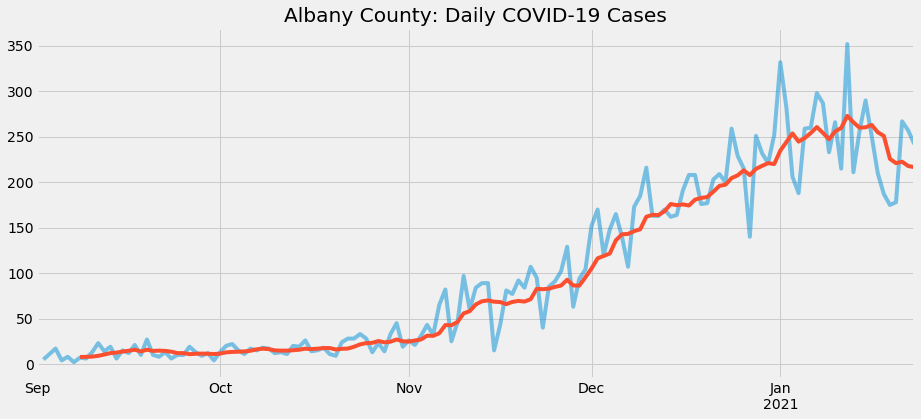

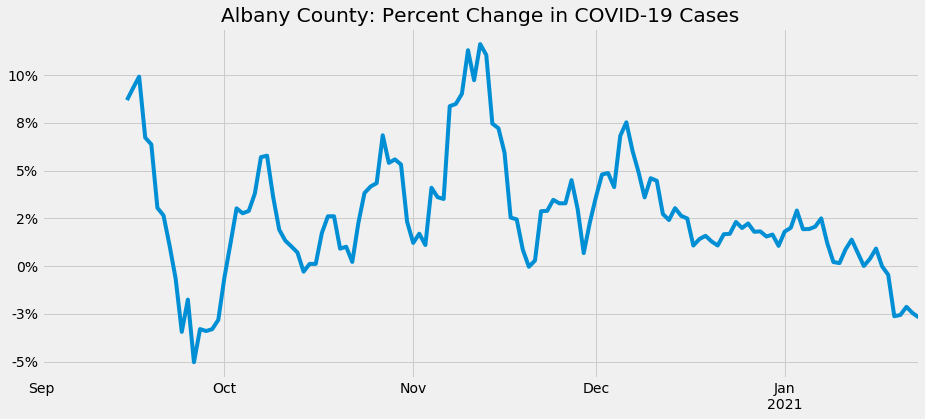

In [140]:
case_plots('Albany')


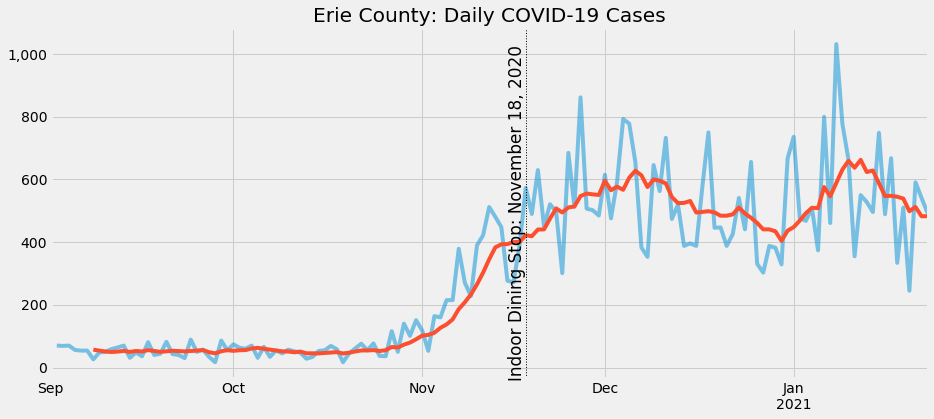

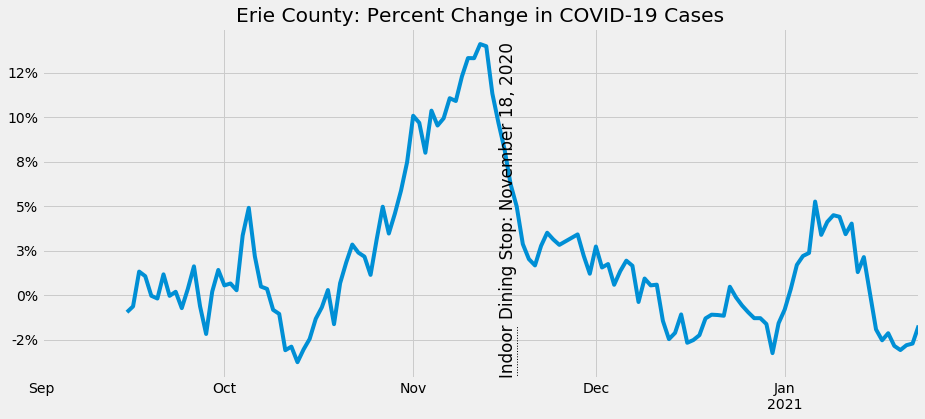

In [139]:
case_plots('Erie')


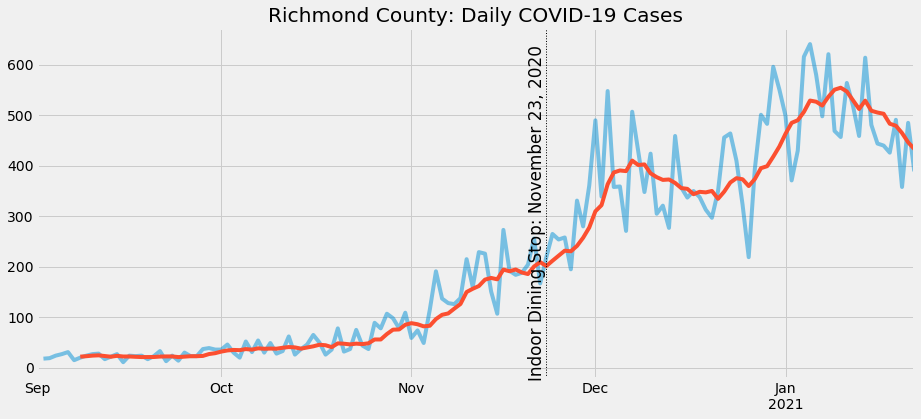

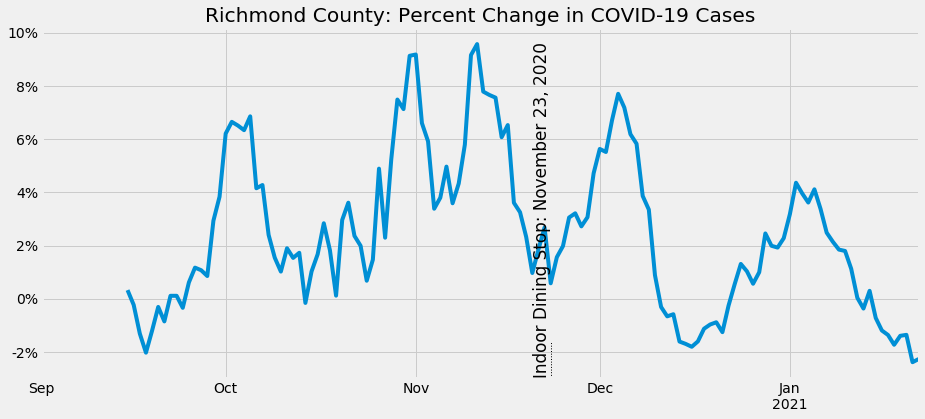

In [137]:
case_plots('Richmond')


In [138]:
# l_cnty_subset = list(dict_orangezns.keys()) + ["Albany", "Thompkins"]
l_cnty_subset = ['Erie','Monroe','Onondaga'] + ["Albany", "Tompkins"]
df_ny_counties = df_counties.query('state=="NY" & county in @l_cnty_subset')
df_ny_counties = df_ny_counties.droplevel(['state','fips']).reset_index()
df_ny_counties = pd.merge(df_ny_counties, pd.to_datetime(pd.Series(dict_orangezns, name='org_zn_start')), 
                          how='left', left_on='county', right_index=True)
df_ny_counties['d_from_id_ban'] = df_ny_counties.dt \
    - df_ny_counties.org_zn_start.fillna(pd.Timestamp('2020-11-23'))
df_ny_counties = df_ny_counties.set_index(['county','dt']).unstack('county')
df_ny_counties
# df_pcts.rolling(7).mean().pct_change().rolling(7).mean().loc['2020-10-01':].plot()


pop2019                                            cases  \
county        Albany      Erie    Monroe  Onondaga  Tompkins   Albany   
dt                                                                      
2020-02-15       NaN       NaN       NaN       NaN       NaN      NaN   
2020-02-16       NaN       NaN       NaN       NaN       NaN      NaN   
2020-02-17       NaN       NaN       NaN       NaN       NaN      NaN   
2020-02-18       NaN       NaN       NaN       NaN       NaN      NaN   
2020-02-19       NaN       NaN       NaN       NaN       NaN      NaN   
...              ...       ...       ...       ...       ...      ...   
2021-01-19  305506.0  918702.0  741770.0  460528.0  102180.0  16343.0   
2021-01-20  305506.0  918702.0  741770.0  460528.0  102180.0  16521.0   
2021-01-21  305506.0  918702.0  741770.0  460528.0  102180.0  16788.0   
2021-01-22  305506.0  918702.0  741770.0  460528.0  102180.0  17045.0   
2021-01-23  305506.0  918702.0  741770.0  460528.0  102180.0  17287.0   

                                                ... org_zn_start             \
county         Erie   Monroe Onondaga Tompkins  ...       Albany       Erie   
dt                                              ...                           
2020-02-15      NaN      NaN      NaN      NaN  ...          NaT 2020-11-18   
2020-02-16      NaN      NaN      NaN      NaN  ...          NaT 2020-11-18   
2020-02-17      NaN      NaN      NaN      NaN  ...          NaT 2020-11-18   
2020-02-18      NaN      NaN      NaN      NaN  ...          NaT 2020-11-18   
2020-02-19      NaN      NaN      NaN      NaN  ...          NaT 2020-11-18   
...             ...      ...      ...      ...  ...          ...        ...   
2021-01-19  52228.0  44319.0  27755.0   2657.0  ...          NaT 2020-11-18   
2021-01-20  52473.0  44632.0  27948.0   2707.0  ...          NaT 2020-11-18   
2021-01-21  53064.0  45003.0  28226.0   2752.0  ...          NaT 2020-11-18   
2021-01-22  53605.0  45401.0  28476.0   2779.0  ...          NaT 2020-11-18   
2021-01-23  54097.0  45707.0  28797.0   2811.0  ...          NaT 2020-11-18   

                                          d_from_id_ban                      \
county         Monroe   Onondaga Tompkins        Albany      Erie    Monroe   
dt                                                                            
2020-02-15 2020-11-23 2020-11-23      NaT     -282 days -277 days -282 days   
2020-02-16 2020-11-23 2020-11-23      NaT     -281 days -276 days -281 days   
2020-02-17 2020-11-23 2020-11-23      NaT     -280 days -275 days -280 days   
2020-02-18 2020-11-23 2020-11-23      NaT     -279 days -274 days -279 days   
2020-02-19 2020-11-23 2020-11-23      NaT     -278 days -273 days -278 days   
...               ...        ...      ...           ...       ...       ...   
2021-01-19 2020-11-23 2020-11-23      NaT       57 days   62 days   57 days   
2021-01-20 2020-11-23 2020-11-23      NaT       58 days   63 days   58 days   
2021-01-21 2020-11-23 2020-11-23      NaT       59 days   64 days   59 days   
2021-01-22 2020-11-23 2020-11-23      NaT       60 days   65 days   60 days   
2021-01-23 2020-11-23 2020-11-23      NaT       61 days   66 days   61 days   

                                
county      Onondaga  Tompkins  
dt                              
2020-02-15 -282 days -282 days  
2020-02-16 -281 days -281 days  
2020-02-17 -280 days -280 days  
2020-02-18 -279 days -279 days  
2020-02-19 -278 days -278 days  
...              ...       ...  
2021-01-19   57 days   57 days  
2021-01-20   58 days   58 days  
2021-01-21   59 days   59 days  
2021-01-22   60 days   60 days  
2021-01-23   61 days   61 days  

[344 rows x 60 columns]

,dt,county,pop2019,cases,deaths,cases_per100k,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,d_from_id_ban,org_zn_start
0,2020-02-15,Albany,NaN,NaN,NaN,NaN,8.0,-4.0,45.0,4.0,0.0,0.0,-274 days,NaN
1,2020-02-15,Erie,NaN,NaN,NaN,NaN,3.0,-2.0,22.0,1.0,0.0,0.0,-274 days,2020-11-18
2,2020-02-15,Monroe,NaN,NaN,NaN,NaN,2.0,-4.0,28.0,2.0,-1.0,0.0,-274 days,2020-11-23
3,2020-02-15,Onondaga,NaN,NaN,NaN,NaN,11.0,-3.0,21.0,9.0,0.0,0.0,-274 days,2020-11-23
4,2020-02-15,Tompkins,NaN,NaN,NaN,NaN,21.0,4.0,34.0,22.0,12.0,-2.0,-274 days,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,2021-01-23,Albany,305506.0,17287.0,270.0,5658.481339,NaN,NaN,NaN,NaN,NaN,NaN,69 days,NaN
1716,2021-01-23,Erie,918702.0,54097.0,1409.0,5888.416483,NaN,NaN,NaN,NaN,NaN,NaN,69 days,2020-11-18
1717,2021-01-23,Monroe,741770.0,45707.0,816.0,6161.883063,NaN,NaN,NaN,NaN,NaN,NaN,69 days,2020-11-23
1718,2021-01-23,Onondaga,460528.0,28797.0,547.0,6253.039989,NaN,NaN,NaN,NaN,NaN,NaN,69 days,2020-11-23


In [98]:
# df_census.query('state=="NY" & SUMLEV==50').sort_values(by='pop2019', ascending=False).iloc[:20]

,state,county,fips,SUMLEV,REGION,DIVISION,pop2019
1884,NY,Kings,36047,50,1,2,2559903
1901,NY,Queens,36081,50,1,2,2253858
1891,NY,New York,36061,50,1,2,1628706
1912,NY,Suffolk,36103,50,1,2,1476601
1863,NY,Bronx,36005,50,1,2,1418207
1890,NY,Nassau,36059,50,1,2,1356924
1920,NY,Westchester,36119,50,1,2,967506
1875,NY,Erie,36029,50,1,2,918702
1888,NY,Monroe,36055,50,1,2,741770
1903,NY,Richmond,36085,50,1,2,476143


# Hosp Data

In [40]:
df_hosp_fac_raw = pd.read_csv(
    'https://healthdata.gov/sites/default/files/reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20210117.csv')
df_hosp_fac_raw.head()


,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_30-39_7_day_sum,previous_day_admission_adult_covid_suspected_40-49_7_day_sum,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum
0,9922a3f069ff4686fe467885206fb1172f609233cfe517...,2021-01-08,PR,NaN,Centro Medico Correccional de Bayamon,NaN,NaN,960.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,976b4ce7c95e1cd394112ce7762ed040f18a141e56a52e...,2021-01-08,PR,NaN,Hospital Industrial C.F.S.E,Paseo Dr. Jose Celso Barbosa,San Juan,935.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0
2,3b081d5ef1c552538e4af4aa593a857bb922a4f364a412...,2021-01-08,LA,NaN,Surgery Center of Zachary,NaN,NaN,70791.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f70d7abf93c78280583ac18e896e6737cca8212b017513...,2021-01-08,NV,NaN,Elite Medical Center,150 E Harmon Ave,Las Vegas,89109.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0
4,ee04edd185865c38c839812cb2eb5ae5d3f8922e3b629e...,2021-01-08,LA,NaN,Alexandria Emergency Hospital,5900 Coliseum Blvd,Alexandria,71303.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
df_hosp_fac = df_hosp_fac_raw.copy()
df_hosp_fac = df_hosp_fac.replace(-999999, np.nan)
df_hosp_fac['dt'] = pd.to_datetime(df_hosp_fac['collection_week'])


In [64]:
this_fips = df_counties.query('state=="NY" & county=="Erie"').index[0][-1]

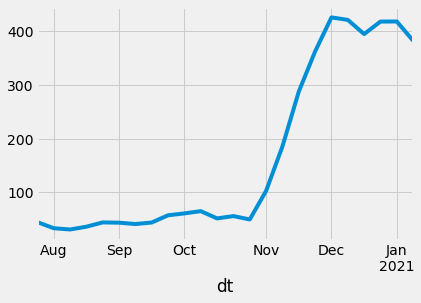

In [66]:
df_hosp_thiscnty = df_hosp_fac.query('fips_code == @this_fips').groupby('dt').sum()

df_hosp_thiscnty['hosp_concur'] = df_hosp_thiscnty[[
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'
]].sum(axis=1)

df_hosp_thiscnty['hosp_concur'].plot()


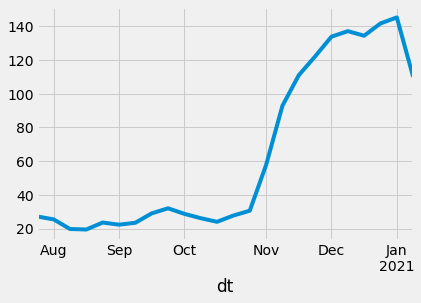

In [72]:
df_hosp_thiscnty = df_hosp_fac.query('fips_code == @this_fips').groupby('dt').sum()

df_hosp_thiscnty['hosp_admit'] = df_hosp_thiscnty[[
    'previous_day_admission_adult_covid_suspected_7_day_sum',
    'previous_day_admission_adult_covid_confirmed_7_day_sum',
    'previous_day_admission_pediatric_covid_suspected_7_day_sum',
    'previous_day_admission_pediatric_covid_confirmed_7_day_sum'
]].sum(axis=1).div(7)

df_hosp_thiscnty['hosp_admit'].plot()
